# Background Stuff
Explain what we are doing here

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import describe
import re
from collections import Counter

from src.utils import prep_data, train_and_evaluate_model, get_x_y

SEED = 2018

Using TensorFlow backend.


In [3]:
number_epochs = [1, 2, 5, 10, 15, 20, 30]
num_trials = len(number_epochs)
scores = []
vocab_size = 200
max_review_len = 300

for counter, epochs in enumerate(number_epochs):
        print('Running trial ' + str(counter + 1) + ' of ' + str(num_trials))
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review_len
        )

        scores.append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                num_epochs=epochs,
                max_review_len=max_review_len,
                verbose=1
            )
        )

Running trial 1 of 7
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step
Running trial 2 of 7
Epoch 1/2
5000/5000 [==============================] - 54s 11ms/step - loss: 0.6899 - acc: 0.5288
Epoch 2/2
5000/5000 [==============================] - 12s 2ms/step
Running trial 3 of 7
Epoch 1/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.6844 - acc: 0.5814
Epoch 2/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.7108 - acc: 0.5356
Epoch 3/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.6824 - acc: 0.5626
Epoch 4/5
5000/5000 [==============================] - 54s 11ms/step - loss: 0.6717 - acc: 0.5892
Epoch 5/5
5000/5000 [==============================] - 12s 2ms/step
Running trial 4 of 7
Epoch 1/10
5000/5000 [==============================] - 54s 11ms/step - loss: 0.6742 - acc: 0.5760
Epoch 2/10
5000/5000 [==============================] - 53s 11ms/step - loss: 0.6025 - acc: 0.6792
Epoch 3/10
5000/5000 [==

5000/5000 [==============================] - 52s 10ms/step - loss: 0.4937 - acc: 0.7648
Epoch 26/30
5000/5000 [==============================] - 53s 11ms/step - loss: 0.5039 - acc: 0.7558
Epoch 27/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.4970 - acc: 0.7608
Epoch 28/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.5014 - acc: 0.7594
Epoch 29/30
5000/5000 [==============================] - 52s 10ms/step - loss: 0.5415 - acc: 0.7244
Epoch 30/30
5000/5000 [==============================] - 12s 2ms/step


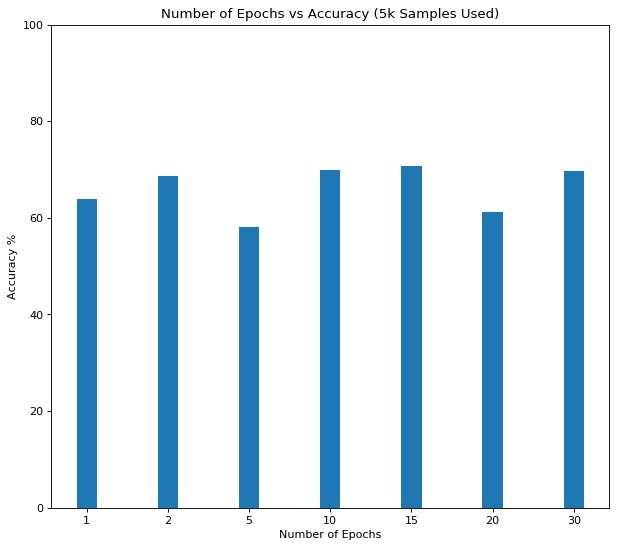

In [7]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
width = 0.25
x_range = np.arange(len(scores))
plt.bar(x_range, scores, width)
plt.xticks(x_range, number_epochs)
plt.ylim([0, 100])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy %')
plt.title('Number of Epochs vs Accuracy (5k Samples Used)')

plt.show()

## Comparison of Max Review Lenghts

In [ ]:
max_review_lengths = [10, 50, 100, 200, 300, 400, 500]
vocab_sizes = [100, 250, 500]
scores = {}
counter = 1
num_trials = len(max_review_lengths) * len(vocab_sizes)

for vocab_size in vocab_sizes:
    scores[vocab_size] = []
    for max_review in max_review_lengths:
        print('Running trial ' + str(counter) + ' of ' + str(num_trials))
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review
        )

        scores[vocab_size].append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                num_epochs=2,
                max_review_len=max_review,
                verbose=0
            )
        )

        counter += 1

In [ ]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
x_range = np.arange(len(next(iter(scores.values()))))
width = 0.25
legend_values = []

for counter, vocab_size in enumerate(scores):
    plt.bar(x_range + width*(counter - 1), scores[vocab_size], width)
    legend_values.append('Vocab Size ' + str(vocab_size))
    
plt.xticks(x_range, max_review_lengths)
plt.ylim([0, 100])
plt.xlabel('Max Review Lengths')
plt.ylabel('Accuracy %')
plt.title('Length of Reviews vs Accuracy (5k Samples Used)')
plt.legend(legend_values)

plt.show()

In [ ]:
embed_lengths = [8, 32, 64, 128, 256]
scores = []
vocab_size = 500
max_review_len = 300

x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review
        )

for counter, embed_len in enumerate(embed_lengths):
        print('Running trial ' + str(counter + 1) + ' of ' + str(len(embed_lengths)))
        scores.append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                vocab_size=vocab_size,
                embed_length=embed_len,
                num_epochs=3,
                max_review_len=max_review,
                verbose=1
            )
        )

In [ ]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
width = 0.25
x_range = np.arange(len(scores))
plt.bar(x_range, scores, width)
plt.xticks(x_range, embed_lengths)
plt.ylim([0, 100])
plt.xlabel('Embedded Vector Length')
plt.ylabel('Accuracy %')
plt.title('Embedded Vector Length vs Accuracy (5k Samples Used)')

plt.show()

In [ ]:
num_reviews = [1000, 2500, 5000, 10000, 25000]
scores = []
vocab_size = 200
max_review_len = 300

for counter, n_samples in enumerate(num_reviews):
        print('Running trial ' + str(counter + 1) + ' of ' + str(len(num_reviews)))
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review,
            n_samples=n_samples
        )

        scores.append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                vocab_size=vocab_size,
                num_epochs=3,
                max_review_len=max_review,
                verbose=1
            )
        )

In [ ]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
width = 0.25
x_range = np.arange(len(scores))
plt.bar(x_range, scores, width)
plt.xticks(x_range, num_reviews)
plt.ylim([0, 100])
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy %')
plt.title('Number of Samples vs Accuracy')

plt.show()

In [8]:
lstm_lengths = [10, 25, 50] #, 100, 150, 200, 500]
scores = []
vocab_size = 200
max_review_len = 300

for counter, lstm_len in enumerate(lstm_lengths):
        print('Running trial ' + str(counter + 1) + ' of ' + str(len(lstm_lengths)))
        x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
            vocab_size=vocab_size,
            max_review_len=max_review_len,
            n_samples=5000
        )

        scores.append(
            train_and_evaluate_model(
                x_train=x_train_pad_sub,
                y_train=y_train_sub,
                x_test=x_test_pad_sub,
                y_test=y_test_sub,
                num_epochs=3,
                lstm_len=lstm_len,
                max_review_len=max_review_len,
                verbose=1
            )
        )

Running trial 1 of 3
Epoch 1/3
5000/5000 [==============================] - 54s 11ms/step - loss: 0.6784 - acc: 0.5754
Epoch 2/3
5000/5000 [==============================] - 52s 10ms/step - loss: 0.6115 - acc: 0.6708
Epoch 3/3
5000/5000 [==============================] - 12s 2ms/step
Running trial 2 of 3
Epoch 1/3
5000/5000 [==============================] - 53s 11ms/step - loss: 0.6929 - acc: 0.5468
Epoch 2/3
5000/5000 [==============================] - 53s 11ms/step - loss: 0.6812 - acc: 0.5680
Epoch 3/3
5000/5000 [==============================] - 13s 3ms/step
Running trial 3 of 3
Epoch 1/3
5000/5000 [==============================] - 58s 12ms/step - loss: 0.6940 - acc: 0.5432
Epoch 2/3
5000/5000 [==============================] - 56s 11ms/step - loss: 0.6162 - acc: 0.6646
Epoch 3/3
5000/5000 [==============================] - 12s 2ms/step


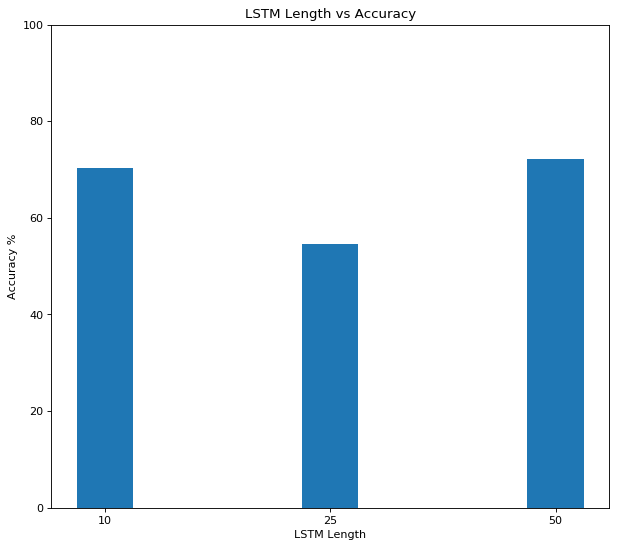

In [9]:
fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
width = 0.25
x_range = np.arange(len(scores))
plt.bar(x_range, scores, width)
plt.xticks(x_range, lstm_lengths)
plt.ylim([0, 100])
plt.xlabel('LSTM Length')
plt.ylabel('Accuracy %')
plt.title('LSTM Length vs Accuracy')

plt.show()